In [ ]:
import pandas as pd
import numpy as np
import scipy.io as sio
import os
import matplotlib.pyplot as plt
import os
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Conv2D, Dropout, BatchNormalization, \
                         Reshape, Activation, Flatten, AveragePooling2D, Conv3D, MaxPool2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, DepthwiseConv2D
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, MaxPool2D, \
    Lambda, AveragePooling2D, TimeDistributed, ConvLSTM2D, Reshape, SpatialDropout2D, SeparableConv2D
from tensorflow.keras.constraints import max_norm


###Data Loading

In [ ]:
path_ms = 'drive/MyDrive/MS_preprocessed/'
path_hc = 'drive/MyDrive/HC_preprocessed/'

In [ ]:
files_ms = os.listdir(path_ms)
files_hc = os.listdir(path_hc)

In [ ]:
files = files_ms + files_hc

In [ ]:
X = []
y = []
for file in files:
    if file.startswith('MS'):
        file = os.path.join(path_ms,file)
        loaded_data = sio.loadmat(file)
        #print(loaded_data['EEG_data_preprocessed'].shape)
        raw_data = loaded_data['EEG_data_preprocessed'].transpose(2,0,1)
        for i in range(raw_data.shape[0]):
            X.append(raw_data[i])
            y.append(1)
        #print(i)    
    if file.startswith('HC'):
        file = os.path.join(path_hc,file)
        loaded_data = sio.loadmat(file)
        #print(loaded_data['EEG_data_preprocessed'].shape)
        raw_data = loaded_data['EEG_data_preprocessed'].transpose(2,0,1)
        for i in range(raw_data.shape[0]):
            X.append(raw_data[i])
            y.append(0)
        #print(i)        

In [ ]:
X = np.array(X)
y = np.array(y)
X = X[:,:,99:, np.newaxis]
X.shape

(1408, 9, 512, 1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [ ]:
print(y_test.shape)
print(np.unique(y, return_counts=True))
print(np.unique(y_test, return_counts=True))
print(np.unique(y_train, return_counts=True))

(352,)
(array([0, 1]), array([818, 590]))
(array([0, 1]), array([194, 158]))
(array([0, 1]), array([624, 432]))


###Shallow CNN

In [ ]:
def my_model():
  input_shape = (9, 512, 1)
  model = Sequential()
  model.add(Conv2D(input_shape=input_shape, filters=40, kernel_size=(1, 25), strides=(1, 1),
                  padding='valid', activation=None))
  model.add(Reshape(target_shape=(9, 488, 40, 1)))
  model.add(Dropout(0.5))

  # Conv Block 2
  #print(model.output_shape)
  model.add(Conv3D(filters=40, kernel_size=(9, 1, 40), padding='valid',
                  data_format='channels_last'))

  model.add(BatchNormalization())
  model.add(Activation(tensorflow.keras.backend.square))  # custom squaring activation function
  #print(model.output_shape)
  model.add(Flatten())
  model.add(Reshape(target_shape=(488, 40, 1)))
  model.add(Dropout(0.5))

  # Pooling
  model.add(AveragePooling2D(pool_size=(75, 1), strides=(15, 1), data_format='channels_last'))
  model.add(Activation(tensorflow.keras.backend.log)) 
  model.add(Flatten())
  model.add(Dense(2))
  model.add(Activation('softmax'))
  #model.summary()
  return model

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:

kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
cvscores = []
ii = 1
for train, test in kfold.split(X, y):
    print('Run ' + str(ii) + '...')
    # create callbacks
    #model_name_str = 'GRAZ_CNN_STFT_3layer_' + \
    #                 '_run_' + str(ii)
    #callbacks_list = model.get_callbacks(model_name_str)

    # initialize and create the model
    model = my_model()
    #model.create_model(x_subject.shape[1:], dropout = DROPOUT, print_summary = False)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    # fit model. If you specify monitor=True, then the model will create callbacks
    # and write its state to a HDF5 file
    #model.fit(x_subject[train], y_subject[train], monitor=True,
    #          epochs = 100, 
    #          batch_size = 256, 
    #          verbose = 0, 
    #          validation_split = 0.1, callbacks = callbacks_list)
    model.fit(X[train], y[train],
          epochs=20,
          batch_size=16,
          validation_split=0.2,
          #validation_data=(X_test, y_test),
          verbose=1)
    # evaluate the model
    print('Evaluating model on test set...')
    scores = model.evaluate(X[test], y[test], verbose = 0)
    print("Result on test set: %s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
    cvscores.append(scores[1] * 100)
    ii += 1

Run 1...
Epoch 1/20
57/57 [==============================] - 12s 196ms/step - loss: 0.7647 - accuracy: 0.6200 - val_loss: 0.8195 - val_accuracy: 0.5398
Epoch 2/20
57/57 [==============================] - 9s 166ms/step - loss: 0.5073 - accuracy: 0.7578 - val_loss: 1.0935 - val_accuracy: 0.4071
Epoch 3/20
57/57 [==============================] - 9s 164ms/step - loss: 0.3876 - accuracy: 0.8133 - val_loss: 2.0345 - val_accuracy: 0.1681
Epoch 4/20
57/57 [==============================] - 10s 172ms/step - loss: 0.3793 - accuracy: 0.8322 - val_loss: 0.5590 - val_accuracy: 0.7168
Epoch 5/20
57/57 [==============================] - 9s 165ms/step - loss: 0.3767 - accuracy: 0.8300 - val_loss: 1.4304 - val_accuracy: 0.4027
Epoch 6/20
57/57 [==============================] - 9s 164ms/step - loss: 0.3325 - accuracy: 0.8611 - val_loss: 0.3297 - val_accuracy: 0.8761
Epoch 7/20
57/57 [==============================] - 9s 165ms/step - loss: 0.2363 - accuracy: 0.9011 - val_loss: 0.8715 - val_accuracy: 0.

In [ ]:
cvscores
np.mean(cvscores), np.std(cvscores)

(88.35036873817444, 2.4409802629203083)

In [ ]:
model_scnn_single = my_model()

In [ ]:
model_scnn_single.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
History_SCNN = model_scnn_single.fit(X_train, y_train,
          epochs=20,
          batch_size=16,
          validation_split=0.2,
          #validation_data=(X_test, y_test),
          verbose=1)

Epoch 1/20
53/53 [==============================] - 9s 167ms/step - loss: 0.7410 - accuracy: 0.5877 - val_loss: 0.7347 - val_accuracy: 0.6179
Epoch 2/20
53/53 [==============================] - 9s 171ms/step - loss: 0.5295 - accuracy: 0.7488 - val_loss: 0.4817 - val_accuracy: 0.7642
Epoch 3/20
53/53 [==============================] - 9s 162ms/step - loss: 0.4053 - accuracy: 0.8258 - val_loss: 0.3403 - val_accuracy: 0.8349
Epoch 4/20
53/53 [==============================] - 9s 163ms/step - loss: 0.3776 - accuracy: 0.8246 - val_loss: 0.4494 - val_accuracy: 0.8208
Epoch 5/20
53/53 [==============================] - 9s 161ms/step - loss: 0.3168 - accuracy: 0.8685 - val_loss: 0.3036 - val_accuracy: 0.8443
Epoch 6/20
53/53 [==============================] - 9s 161ms/step - loss: 0.2917 - accuracy: 0.8803 - val_loss: 0.3577 - val_accuracy: 0.8538
Epoch 7/20
53/53 [==============================] - 9s 169ms/step - loss: 0.2765 - accuracy: 0.8791 - val_loss: 0.2784 - val_accuracy: 0.8726
Epoch 

In [ ]:
score = model_scnn_single.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.2594476044178009
Test accuracy: 0.8920454382896423


In [ ]:
y_pred = model_scnn_single(X_test)
y_pred = np.argmax(y_pred, axis = 1)
np.unique(y_pred, return_counts = True)

(array([0, 1]), array([216, 136]))

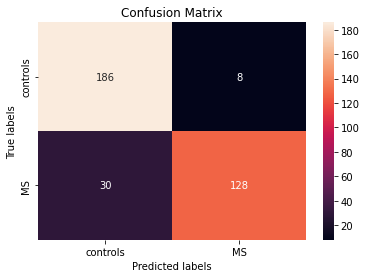

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['controls', 'MS']); ax.yaxis.set_ticklabels(['controls', 'MS']);

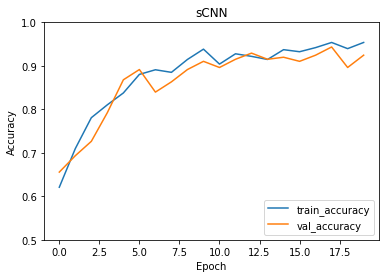

In [ ]:
plt.plot(History_SCNN.history['accuracy'], label='train_accuracy')
plt.plot(History_SCNN.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('sCNN')
plt.savefig('drive/MyDrive/sCNN_accuracy.png')
#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

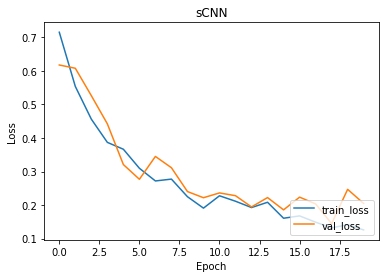

In [ ]:
plt.plot(History_SCNN.history['loss'], label='train_loss')
plt.plot(History_SCNN.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('sCNN')
plt.savefig('drive/MyDrive/sCNN_loss.png')

###Deep CNN

In [ ]:
def dcnn():
  input_shape = (9,512,1)
  model_dcnn = Sequential()
  model_dcnn.add(Conv2D(input_shape=(9,512,1), filters=25, kernel_size=(1, 10), strides=(1, 1),
                    padding="valid",
                    activation="relu"))
  # print(model.output_shape)
  model_dcnn.add(Reshape(target_shape=(input_shape[0], 503, 25, 1)))
  model_dcnn.add(Conv3D(filters=25, kernel_size=(input_shape[0], 1, 25), data_format="channels_last"))
  model_dcnn.add(BatchNormalization())
  model.add(Activation(activation="relu"))
  # print(model.output_shape)
  model_dcnn.add(Flatten())
  # print(model.output_shape)
  model_dcnn.add(Reshape(target_shape=(503, 25, 1)))
  model_dcnn.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1), data_format="channels_last"))
  model_dcnn.add(Dropout(0.5))

  # Conv Pool Block 2
  model_dcnn.add(Conv2D(filters=50, kernel_size=(10, 25)))
  model_dcnn.add(BatchNormalization())
  model_dcnn.add(Activation(activation="relu"))
  model_dcnn.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
  # print(model.output_shape)
  model_dcnn.add(Flatten())
  model_dcnn.add(Reshape(target_shape=(52, 50, 1)))
  model_dcnn.add(Dropout(0.5))

  # Conv Pool Block 3
  model_dcnn.add(Conv2D(filters=100, kernel_size=(10, 50)))
  model_dcnn.add(BatchNormalization())
  model_dcnn.add(Activation(activation="relu"))
  model_dcnn.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
  # print(model.output_shape)
  model_dcnn.add(Flatten())
  model_dcnn.add(Reshape(target_shape=(14, 100, 1)))
  model_dcnn.add(Dropout(0.5))

  # Conv Pool Block 4
  model_dcnn.add(Conv2D(filters=200, kernel_size=(10, 100)))

  model_dcnn.add(BatchNormalization())
  model_dcnn.add(Activation(activation="relu"))
  model_dcnn.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))

  # Softmax for classification
  model_dcnn.add(Flatten())
  model_dcnn.add(Dense(2))
  model_dcnn.add(Activation("softmax"))
  return model_dcnn

In [ ]:
#model_dcnn.summary()

In [ ]:
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
cvscores_dcnn = []
ii = 1
for train, test in kfold.split(X, y):
    print('Run ' + str(ii) + '...')
    # create callbacks
    #model_name_str = 'GRAZ_CNN_STFT_3layer_' + \
    #                 '_run_' + str(ii)
    #callbacks_list = model.get_callbacks(model_name_str)

    # initialize and create the model
    model_dcnn = dcnn()
    #model.create_model(x_subject.shape[1:], dropout = DROPOUT, print_summary = False)
    model_dcnn.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    # fit model. If you specify monitor=True, then the model will create callbacks
    # and write its state to a HDF5 file
    #model.fit(x_subject[train], y_subject[train], monitor=True,
    #          epochs = 100, 
    #          batch_size = 256, 
    #          verbose = 0, 
    #          validation_split = 0.1, callbacks = callbacks_list)
    model_dcnn.fit(X[train], y[train],
          epochs=20,
          batch_size=16,
          validation_split=0.1,
          validation_data=(X[test], y[test]),
          verbose=1)
    # evaluate the model
    print('Evaluating model on test set...')
    scores = model_dcnn.evaluate(X[test], y[test], verbose = 0)
    print("Result on test set: %s: %.2f%%" % (model_dcnn.metrics_names[1], scores[1] * 100))
    cvscores_dcnn.append(scores[1] * 100)
    ii += 1

Run 1...
Epoch 1/20
71/71 [==============================] - 11s 138ms/step - loss: 0.9482 - accuracy: 0.5666 - val_loss: 0.6662 - val_accuracy: 0.6028
Epoch 2/20
71/71 [==============================] - 9s 132ms/step - loss: 0.6736 - accuracy: 0.6261 - val_loss: 0.7334 - val_accuracy: 0.5780
Epoch 3/20
71/71 [==============================] - 9s 128ms/step - loss: 0.6501 - accuracy: 0.6607 - val_loss: 0.6381 - val_accuracy: 0.6879
Epoch 4/20
71/71 [==============================] - 9s 129ms/step - loss: 0.5949 - accuracy: 0.7167 - val_loss: 0.6412 - val_accuracy: 0.6844
Epoch 5/20
71/71 [==============================] - 9s 133ms/step - loss: 0.5941 - accuracy: 0.7007 - val_loss: 0.6260 - val_accuracy: 0.6631
Epoch 6/20
71/71 [==============================] - 9s 133ms/step - loss: 0.5371 - accuracy: 0.7371 - val_loss: 0.5742 - val_accuracy: 0.7021
Epoch 7/20
71/71 [==============================] - 10s 144ms/step - loss: 0.5413 - accuracy: 0.7371 - val_loss: 0.5200 - val_accuracy: 0.

In [ ]:
np.mean(cvscores_dcnn),np.std(cvscores_dcnn) 

(82.81946539878845, 4.356267793090671)

In [ ]:
model_dcnn.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
History_DCNN = model_dcnn.fit(X_train, y_train,
          epochs=20,
          batch_size=16,
          validation_split=0.2,
          #validation_data=(X_test, y_test),
          verbose=1)

Epoch 1/20
53/53 [==============================] - 9s 141ms/step - loss: 0.8786 - accuracy: 0.5592 - val_loss: 0.6860 - val_accuracy: 0.6038
Epoch 2/20
53/53 [==============================] - 8s 148ms/step - loss: 0.6607 - accuracy: 0.6197 - val_loss: 0.6455 - val_accuracy: 0.6226
Epoch 3/20
53/53 [==============================] - 7s 137ms/step - loss: 0.6457 - accuracy: 0.6434 - val_loss: 0.6457 - val_accuracy: 0.6132
Epoch 4/20
53/53 [==============================] - 7s 136ms/step - loss: 0.6044 - accuracy: 0.6860 - val_loss: 0.6380 - val_accuracy: 0.6792
Epoch 5/20
53/53 [==============================] - 7s 131ms/step - loss: 0.6051 - accuracy: 0.6991 - val_loss: 0.8055 - val_accuracy: 0.6038
Epoch 6/20
53/53 [==============================] - 7s 133ms/step - loss: 0.5755 - accuracy: 0.7014 - val_loss: 0.7273 - val_accuracy: 0.5849
Epoch 7/20
53/53 [==============================] - 7s 139ms/step - loss: 0.5578 - accuracy: 0.7168 - val_loss: 0.5242 - val_accuracy: 0.7358
Epoch 

In [ ]:
score_dcnn = model_dcnn.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score_dcnn[0])
print("Test accuracy:", score_dcnn[1])

Test loss: 0.45500853657722473
Test accuracy: 0.78125


In [ ]:
pred_dcnn = model_dcnn.predict(X_test)
pred_dcnn = np.argmax(pred_dcnn, axis=1) 
pred_dcnn

11/11 [==============================] - 1s 67ms/step


array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,

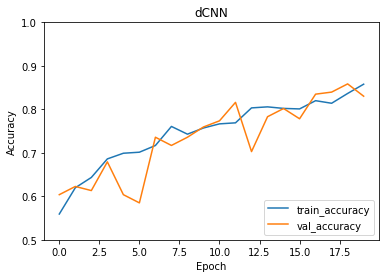

In [ ]:
plt.plot(History_DCNN.history['accuracy'], label='train_accuracy')
plt.plot(History_DCNN.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('dCNN')
plt.savefig('drive/MyDrive/dCNN_accuracy.png')
#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
plt.plot(History_DCNN.history['loss'], label='train_loss')
plt.plot(History_DCNN.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('dCNN')
plt.savefig('drive/MyDrive/dCNN_loss.png')
#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

NameError: ignored

###EGGNEt

In [ ]:
input_shape = (9, 512, 1)
def eegnet():
  model_egg = Sequential()

  ##################################################################
  model_egg.add(Conv2D(7, (1, 15), padding='same',
                  input_shape=input_shape,
                  use_bias=False))
  model_egg.add(BatchNormalization(axis=1))
  model_egg.add(DepthwiseConv2D((8, 1), use_bias=False,
                          depth_multiplier=2,
                          depthwise_constraint=max_norm(1.)))
  model_egg.add(BatchNormalization(axis=1))
  model_egg.add(Activation('elu'))
  model_egg.add(AveragePooling2D((1, 4)))
  model_egg.add(Dropout(0.5))

  model_egg.add(SeparableConv2D(7, (1, 16), use_bias=False, padding='same'))
  model_egg.add(BatchNormalization(axis=1))
  model_egg.add(Activation('elu'))
  model_egg.add(AveragePooling2D((1, 8)))
  model_egg.add(Dropout(0.5))
  model_egg.add(Flatten())

  model_egg.add(Dense(2, name='dense', kernel_constraint=max_norm(0.25)))
  model_egg.add(Activation('softmax', name='softmax'))
  return model_egg

In [ ]:
model_egg.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 9, 512, 7)         105       
                                                                 
 batch_normalization_16 (Bat  (None, 9, 512, 7)        36        
 chNormalization)                                                
                                                                 
 depthwise_conv2d_2 (Depthwi  (None, 2, 512, 14)       112       
 seConv2D)                                                       
                                                                 
 batch_normalization_17 (Bat  (None, 2, 512, 14)       8         
 chNormalization)                                                
                                                                 
 activation_19 (Activation)  (None, 2, 512, 14)        0         
                                                      

In [ ]:
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
cvscores_eeg = []
ii = 1
for train, test in kfold.split(X, y):
    print('Run ' + str(ii) + '...')
    # create callbacks
    #model_name_str = 'GRAZ_CNN_STFT_3layer_' + \
    #                 '_run_' + str(ii)
    #callbacks_list = model.get_callbacks(model_name_str)

    # initialize and create the model
    model_eeg = eegnet()
    #model.create_model(x_subject.shape[1:], dropout = DROPOUT, print_summary = False)
    model_eeg.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    # fit model. If you specify monitor=True, then the model will create callbacks
    # and write its state to a HDF5 file
    #model.fit(x_subject[train], y_subject[train], monitor=True,
    #          epochs = 100, 
    #          batch_size = 256, 
    #          verbose = 0, 
    #          validation_split = 0.1, callbacks = callbacks_list)
    model_eeg.fit(X[train], y[train],
          epochs=20,
          batch_size=16,
          #validation_split=0.1,
          validation_data=(X[test], y[test]),
          verbose=1)
    # evaluate the model
    print('Evaluating model on test set...')
    scores = model_eeg.evaluate(X[test], y[test], verbose = 0)
    print("Result on test set: %s: %.2f%%" % (model_eeg.metrics_names[1], scores[1] * 100))
    cvscores_eeg.append(scores[1] * 100)
    ii += 1

Run 1...
Epoch 1/20
71/71 [==============================] - 13s 165ms/step - loss: 0.6534 - accuracy: 0.6163 - val_loss: 0.6733 - val_accuracy: 0.5816
Epoch 2/20
71/71 [==============================] - 11s 154ms/step - loss: 0.6185 - accuracy: 0.6634 - val_loss: 1350394355905369997312.0000 - val_accuracy: 0.6206
Epoch 3/20
71/71 [==============================] - 11s 156ms/step - loss: 0.6041 - accuracy: 0.6634 - val_loss: 15863773322433509856378880.0000 - val_accuracy: 0.6277
Epoch 4/20
71/71 [==============================] - 9s 123ms/step - loss: 0.5973 - accuracy: 0.6634 - val_loss: 5347037192214728135018889084928.0000 - val_accuracy: 0.5567
Epoch 5/20
71/71 [==============================] - 9s 121ms/step - loss: 0.5922 - accuracy: 0.6794 - val_loss: 24531551065818952431009005568.0000 - val_accuracy: 0.6277
Epoch 6/20
71/71 [==============================] - 8s 110ms/step - loss: 0.5828 - accuracy: 0.6945 - val_loss: 0.6496 - val_accuracy: 0.6596
Epoch 7/20
71/71 [==============

In [ ]:
np.mean(cvscores_eeg), np.std(cvscores_eeg)

(64.04936730861664, 8.80595426595955)

In [ ]:
model_egg.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
History_EGG = model_egg.fit(X_train, y_train,
          epochs=20,
          batch_size=16,
          validation_split=0.2,
          #validation_data=(X_test, y_test),
          verbose=1)

Epoch 1/20
53/53 [==============================] - 7s 111ms/step - loss: 0.6693 - accuracy: 0.6173 - val_loss: 9929959424.0000 - val_accuracy: 0.4764
Epoch 2/20
53/53 [==============================] - 6s 108ms/step - loss: 0.6349 - accuracy: 0.6517 - val_loss: 0.6944 - val_accuracy: 0.5377
Epoch 3/20
53/53 [==============================] - 6s 106ms/step - loss: 0.6261 - accuracy: 0.6434 - val_loss: 172915210057381160466639749120.0000 - val_accuracy: 0.6462
Epoch 4/20
53/53 [==============================] - 6s 107ms/step - loss: 0.6044 - accuracy: 0.6754 - val_loss: 0.6895 - val_accuracy: 0.5377
Epoch 5/20
53/53 [==============================] - 6s 106ms/step - loss: 0.5997 - accuracy: 0.6694 - val_loss: 263784232625510351254914596864.0000 - val_accuracy: 0.6651
Epoch 6/20
53/53 [==============================] - 7s 128ms/step - loss: 0.5779 - accuracy: 0.7073 - val_loss: 11859906560.0000 - val_accuracy: 0.6651
Epoch 7/20
53/53 [==============================] - 6s 107ms/step - los

In [ ]:
score_egg = model_egg.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score_egg[0])
print("Test accuracy:", score_egg[1])

Test loss: 2.906348528684699e+29
Test accuracy: 0.6534090638160706


In [ ]:
pred_egg = model_egg.predict(X_test)
pred_egg = np.argmax(pred_egg, axis = 1)
pred_egg

11/11 [==============================] - 1s 60ms/step


array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,